### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulate Signal

In [2]:
def sim_sig_np(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = np.tile(be,(nvox,1))
    bf_tiled = np.tile(bf,(nvox,1))
    tm_tiled = np.tile(tm,(nvox,1))

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled* np.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = np.exp(-adc_prime_tiled * be_tiled)
    
    return normalised_signal_tiled, adc_prime_tiled


In [3]:
def sim_sig_pytorch(bf, be, tm, adc_tiled, sigma_tiled, axr_tiled, batch_size):
    """batch_size and nvox are kind of interchangable
    might be useful to know for testing purposes
    """
    be_tiled = torch.tile(be,(batch_size,1))
    bf_tiled = torch.tile(bf,(batch_size,1))
    tm_tiled = torch.tile(tm,(batch_size,1))

    """
    use this section for testing if function works as intended    
    adc_tiled = torch.tile(adc,(tm.shape[0],1)).t()
    sigma_tiled = torch.tile(sigma,(tm.shape[0],1)).t()
    axr_tiled = torch.tile(axr,(tm.shape[0],1)).t()
    """

    tm_tiled[(tm_tiled == torch.min(tm_tiled)) & (bf_tiled == 0)] = float('inf')
    

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled * torch.exp(-tm_tiled * axr_tiled))
    normalised_signal_tiled = torch.exp(-adc_prime_tiled * be_tiled)

    return normalised_signal_tiled, adc_prime_tiled

### Initial variables.

In [4]:
nvox = 1000 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32)  # mixing time [ms]


sim_adc = np.random.uniform(0.1,3.5,nvox)               # ADC, simulated [um2/ms]
sim_sigma = np.random.uniform(0,1,nvox)                 # sigma, simulated [a.u.]
sim_axr = np.random.uniform(0.1,20,nvox) * 1e-3         # AXR, simulated [ms-1]

sim_E_vox, sim_adc_prime = sim_sig_np(bf,be,tm,sim_adc,sim_sigma,sim_axr,nvox)

In [5]:
"""sim_adc1 = torch.tensor(sim_adc)
sim_sigma1 = torch.tensor(sim_sigma)
sim_axr1 = torch.tensor(sim_axr)
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)

sim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)"""

'sim_adc1 = torch.tensor(sim_adc)\nsim_sigma1 = torch.tensor(sim_sigma)\nsim_axr1 = torch.tensor(sim_axr)\nbe = torch.tensor(be)\nbf = torch.tensor(bf)\ntm = torch.tensor(tm)\n\nsim_E_vox1, sim_adc_prime1 = sim_sig_pytorch(bf,be,tm,sim_adc1,sim_sigma1,sim_axr1,nvox)'

### Histogram plots

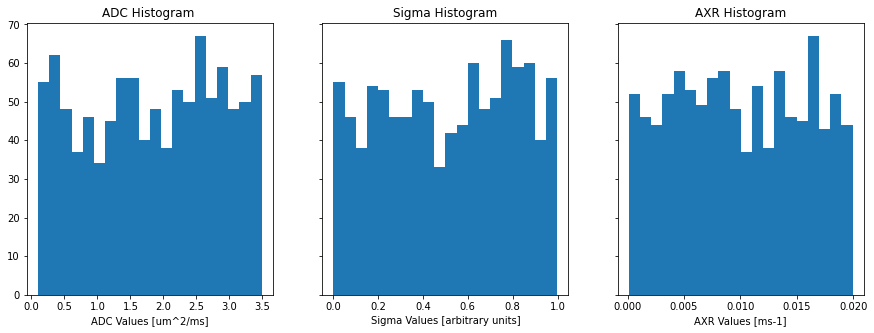

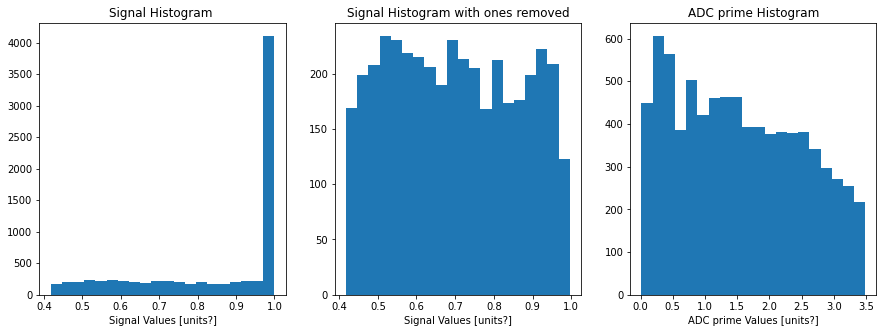

In [6]:
n_bins=20
#make 200 and voxels 100,000 to see adc prime dropoff
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(15, 5))
axs[0].hist(sim_adc, bins=n_bins)
axs[1].hist(sim_sigma, bins=n_bins)
axs[2].hist(sim_axr, bins=n_bins)
axs[0].set_title('ADC Histogram ')
axs[0].set_xlabel('ADC Values [um^2/ms]')
axs[1].set_title('Sigma Histogram')
axs[1].set_xlabel('Sigma Values [arbitrary units]')
axs[2].set_title('AXR Histogram')
axs[2].set_xlabel('AXR Values [ms-1]');


fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].hist(sim_E_vox.flatten(), bins=n_bins)
axs[0].set_title('Signal Histogram ')
axs[0].set_xlabel('Signal Values [units?]')
axs[1].hist(sim_E_vox[sim_E_vox != 1].flatten(), bins=n_bins)
axs[1].set_title('Signal Histogram with ones removed')
axs[1].set_xlabel('Signal Values [units?]')
axs[2].hist(sim_adc_prime.flatten(), bins=n_bins)
axs[2].set_title('ADC prime Histogram')
axs[2].set_xlabel('ADC prime Values [units?]');


### Plotting b-value against normalised signal

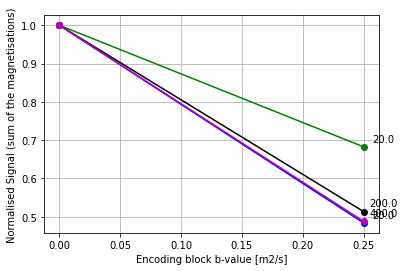

In [7]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Least squares fit
Everything has a 1 suffix for testing the least squares fit.


In [10]:
nvox1 = 15
bf1 = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e6   # filter b-values [s/m2]
be1 = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e6       # encoding b-values [s/m2]
tm1 = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32)* 1e-3  # mixing time [s]

""" Check units again when using these lines
sim_adc1 = np.random.uniform(0.1,3.5,nvox1)* 1e-9               # ADC, simulated [um2/ms]
sim_sigma1 = np.random.uniform(0,1,nvox1)                 # sigma, simulated [a.u.]
sim_axr1 = np.random.uniform(0.1,20,nvox1) * 1e-3         # AXR, simulated [ms-1]"""

sim_adc1 = np.array([1e-9])                           # ADC, simulated [m2/s]
sim_sigma1 = np.array([.2])                               # sigma, simulated [a.u.]
sim_axr1 = np.array([3])                                # AXR, [s-1]

"""note: nvox1 is replace with len(sim_adc1) for now during testing"""
sim_E_vox1, sim_adc_prime1 = sim_sig_np(bf1,be1,tm1,sim_adc1,sim_sigma1,sim_axr1,len(sim_adc1))
sim_E_vox1 = sim_E_vox1[0] #un-nest the array
sim_adc_prime1 = sim_adc_prime1[0] #un-nest the array - consider putting these 2 lines into sim_sig_np, 
#just check if they work when nvox>1

def sse_adc_prime(variables_to_optimize, tm1, be1, sim_E_vox1):

    #calculate adc prime for 1 voxel, for all 8 image volumes, from known adc, sigma, axr and tm
    #calculate adc prime from be values, S(tm, b1) and S(tm, b2)
    #find sse difference between each of 8 values then sum
    sim_adc1, sim_axr1, sim_sigma1 = variables_to_optimize
    

    #tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf
    #calculate adc prime from known adc, sigma, axr and tm
    adc_tm_fit1 = sim_adc1 * (1 - sim_sigma1 * np.exp(-tm1*sim_axr1))
    #remove every 2nd value as they are duplicates. Function breaks without this line
    adc_tm_fit1 = adc_tm_fit1[::2]
    #the first 4 elements were all the same, because tm is the same, but I kept 2/4
    
    #adc1 = np.tile(sim_adc1, (np.size(tm1),1))
    #sigma1 = np.tile(sim_sigma1, (np.size(tm1),1))
    #axr1 = np.tile(sim_axr1, (np.size(tm1),1))

    sim_E_vox1_ones = sim_E_vox1[::2] #this line assumes you alternate the encoding b values
    sim_E_vox1_non_one = sim_E_vox1[1::2]


    #calculate adc prime from be values, S(tm, b1) and S(tm, b2)
    adc_tm_calc1 = -1 / (0 - 250) * np.log(sim_E_vox1_non_one/sim_E_vox1_ones)

    #calculate difference for all 8 image volumes then sum
    sse = np.sum((adc_tm_calc1 - adc_tm_fit1) ** 2)
    #sse=1
    return sse
sse_adc_prime([sim_adc1, sim_axr1, sim_sigma1], tm1, be1, sim_E_vox1)

def sse_adc_prime_2(variables_to_optimize, tm1, be1, sim_E_vox1, sim_adc_prime1):
    #WHAT ARE UNITS? WRITE HERE IF IN MS OR S
    # S is generally more accurate

    #   1. create nsf - number of unique bf and tm combinations
    #   2. create univols - the values of the unique bf and tm combos
    #   3. make adc_tm_calc using similar method to elizabeth
    #   4. extract relevant values from sim_adc_prime1 - most likely every second value - but ideally do it in a more abstract way


    adc_tm_fit1 =  sim_adc_prime1
    adc_tm_fit1 = adc_tm_fit1[::2] # better to do in abstract fashion.
    sse = np.sum((adc_tm_calc1 - adc_tm_fit1) ** 2)
    return sse
sse_adc_prime_2([sim_adc1, sim_axr1, sim_sigma1], tm1, be1, sim_E_vox1, sim_adc_prime1)


3.3344518254044947e-06

In [11]:
#basic minimization function

# Initial guess
initial_guess = [1.1e-9, .15, 3.5]  # Starting values for ADC , sigma, AXR
# Define the bounds for adc, sigma, axr
bounds = [(0.1e-9, 3.5-9), (0, 1), (0.1, 20)]  # Bounds for ADC, sigma, AXR

additional_args = (tm1, be1, sim_E_vox1) 
# Minimize the function using L-BFGS-B method with bounds
result = scipy.optimize.minimize(sse_adc_prime, initial_guess, args=additional_args, bounds=bounds, method='L-BFGS-B')

# Print the result
print("True values of ADC, Sigma, AXR:", sim_adc1,sim_sigma1,sim_axr1)
print("Minimized values of ADC, Sigma, AXR:", result.x)
print("The sse at these values is", result.fun)


True values of ADC, Sigma, AXR: [1.e-09] [0.2] [3]
Minimized values of ADC, Sigma, AXR: [1.1e-09 1.5e-01 3.5e+00]
The sse at these values is 0.0


### Creating the neural network

In [52]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nvox,nparams,batch_size):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        
        # why is self batch and nvox here?
        self.nvox = nvox
        self.batch_size = batch_size

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 

        adc = torch.tile(torch.clamp(params[:, 0].unsqueeze(1), min=0.1, max=3.5), (1, tm.shape[0]))
        sigma = torch.tile(torch.clamp(params[:, 1].unsqueeze(1), min=0, max=1), (1, tm.shape[0]))
        axr = torch.tile(torch.clamp(params[:, 2].unsqueeze(1), min=0.1e-3, max=20e-3), (1, tm.shape[0]))

        E_vox,_ = sim_sig_pytorch(self.bf, self.be, self.tm, adc, sigma, axr, axr.shape[0])
        #axr.shape[0] is either the batch size or nvox

        return E_vox, adc, sigma, axr


### NN continued

In [53]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
be = torch.tensor(be)
bf = torch.tensor(bf)
tm = torch.tensor(tm)
batch_size = 128

#initilise network
net = Net(be, bf, tm, nvox, nparams, batch_size)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

### Training

In [54]:
# train
loss_progress = np.empty(shape=(0,)) 
for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)

        sim_E_vox_batch64 = sim_E_vox_batch.to(torch.float64)
        #needed so that loss comparison works

        loss = criterion(pred_E_vox, sim_E_vox_batch64)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
        loss_progress = np.append(loss_progress, best)
    else:
        num_bad_epochs = num_bad_epochs + 1
        loss_progress = np.append(loss_progress, best)
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc_repeated, final_pred_sigma_repeated, final_pred_axr_repeated = net(torch.from_numpy(sim_E_vox.astype(np.float32)))
    # adc sigma and axr will have 8 columns which are all the same

final_pred_adc = final_pred_adc_repeated[:, 0]
final_pred_sigma = final_pred_sigma_repeated [:, 0]
final_pred_axr = final_pred_axr_repeated[:, 0]


-----------------------------------------------------------------
epoch: 0; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 135.91it/s]


loss: 0.11935182398919018
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 1; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 277.54it/s]


loss: 0.12097247939260222
-----------------------------------------------------------------
epoch: 2; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 307.80it/s]


loss: 0.11903992479250655
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 3; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 243.61it/s]


loss: 0.11789047322467672
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 4; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 263.61it/s]


loss: 0.11734338999184296
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 338.39it/s]


loss: 0.11927674762090734
-----------------------------------------------------------------
epoch: 6; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 326.40it/s]


loss: 0.11866246344670245
-----------------------------------------------------------------
epoch: 7; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 345.95it/s]


loss: 0.11745797334963562
-----------------------------------------------------------------
epoch: 8; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 308.06it/s]


loss: 0.11802891132707097
-----------------------------------------------------------------
epoch: 9; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 362.32it/s]


loss: 0.11713314710879735
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 10; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 357.80it/s]


loss: 0.11809219186714882
-----------------------------------------------------------------
epoch: 11; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 381.76it/s]


loss: 0.11508978382943837
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 12; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 349.91it/s]


loss: 0.11476345987278036
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 13; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 366.45it/s]


loss: 0.11467803569394872
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 14; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 304.52it/s]


loss: 0.11155443898288336
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 15; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 292.30it/s]


loss: 0.11483543189556941
-----------------------------------------------------------------
epoch: 16; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 331.14it/s]


loss: 0.11224632638611481
-----------------------------------------------------------------
epoch: 17; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 350.65it/s]


loss: 0.11409277836884284
-----------------------------------------------------------------
epoch: 18; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 319.17it/s]


loss: 0.1135136961342148
-----------------------------------------------------------------
epoch: 19; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 346.72it/s]


loss: 0.11456076719397844
-----------------------------------------------------------------
epoch: 20; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 335.12it/s]


loss: 0.11162514780194913
-----------------------------------------------------------------
epoch: 21; bad epochs: 6


100%|██████████| 7/7 [00:00<00:00, 376.18it/s]


loss: 0.11102966577393869
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 22; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 328.67it/s]


loss: 0.11297930742188517
-----------------------------------------------------------------
epoch: 23; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 371.47it/s]


loss: 0.10964747716631286
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 24; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 344.76it/s]


loss: 0.11015122514505485
-----------------------------------------------------------------
epoch: 25; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 352.01it/s]


loss: 0.1101985036995623
-----------------------------------------------------------------
epoch: 26; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 364.43it/s]


loss: 0.11130935776858719
-----------------------------------------------------------------
epoch: 27; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 344.96it/s]


loss: 0.10873004515681517
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 28; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 349.89it/s]


loss: 0.10906372174948907
-----------------------------------------------------------------
epoch: 29; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 400.35it/s]


loss: 0.10910923203848841
-----------------------------------------------------------------
epoch: 30; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 265.99it/s]


loss: 0.10805569421540531
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 31; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 340.61it/s]


loss: 0.1070733132008916
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 32; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 384.21it/s]


loss: 0.10806608088511306
-----------------------------------------------------------------
epoch: 33; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 340.42it/s]


loss: 0.10635539092149962
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 34; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 398.31it/s]


loss: 0.10654877842037701
-----------------------------------------------------------------
epoch: 35; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 359.80it/s]


loss: 0.10563256589029285
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 36; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 342.78it/s]


loss: 0.10601737072942059
-----------------------------------------------------------------
epoch: 37; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 292.09it/s]


loss: 0.10493338314026628
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 38; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 328.33it/s]


loss: 0.1052234691606496
-----------------------------------------------------------------
epoch: 39; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 197.85it/s]


loss: 0.10291101886241645
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 40; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 166.88it/s]


loss: 0.10229222616745855
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 41; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 83.37it/s]


loss: 0.10203570727713722
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 42; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 88.76it/s]


loss: 0.10263635489719763
-----------------------------------------------------------------
epoch: 43; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 84.51it/s]


loss: 0.10305576145730444
-----------------------------------------------------------------
epoch: 44; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 133.66it/s]


loss: 0.10227660225060896
-----------------------------------------------------------------
epoch: 45; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 282.46it/s]


loss: 0.10235266821000152
-----------------------------------------------------------------
epoch: 46; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 368.93it/s]


loss: 0.1023710238741326
-----------------------------------------------------------------
epoch: 47; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 343.37it/s]


loss: 0.09968530961737711
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 48; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 338.90it/s]


loss: 0.10018979081941418
-----------------------------------------------------------------
epoch: 49; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 381.78it/s]


loss: 0.10166295842994819
-----------------------------------------------------------------
epoch: 50; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 359.19it/s]


loss: 0.09825242141473894
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 51; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 363.16it/s]


loss: 0.09804001689225107
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 52; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 313.22it/s]


loss: 0.09869437343064415
-----------------------------------------------------------------
epoch: 53; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 358.00it/s]


loss: 0.09842333249140704
-----------------------------------------------------------------
epoch: 54; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 350.88it/s]


loss: 0.09619965058783896
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 55; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 363.75it/s]


loss: 0.09732337190863041
-----------------------------------------------------------------
epoch: 56; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 295.62it/s]


loss: 0.09767022172970785
-----------------------------------------------------------------
epoch: 57; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 322.82it/s]


loss: 0.09594256733482198
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 58; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 189.07it/s]


loss: 0.09472904896711926
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 59; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 112.21it/s]


loss: 0.09514278508610928
-----------------------------------------------------------------
epoch: 60; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 61.59it/s]


loss: 0.09391005592904271
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 61; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 261.77it/s]


loss: 0.09435016360774724
-----------------------------------------------------------------
epoch: 62; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 85.40it/s]


loss: 0.09195086231056365
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 63; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 129.42it/s]


loss: 0.09254962274997468
-----------------------------------------------------------------
epoch: 64; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 98.48it/s]


loss: 0.09298797160629202
-----------------------------------------------------------------
epoch: 65; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 103.76it/s]


loss: 0.09121671081112477
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 66; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 129.88it/s]


loss: 0.09026804575610951
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 67; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 72.32it/s]


loss: 0.09017871166709324
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 68; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 264.51it/s]


loss: 0.09024789860143291
-----------------------------------------------------------------
epoch: 69; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 203.26it/s]


loss: 0.09047827887981619
-----------------------------------------------------------------
epoch: 70; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 120.93it/s]


loss: 0.08971571723560424
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 71; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 107.04it/s]


loss: 0.08979467942567701
-----------------------------------------------------------------
epoch: 72; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 132.52it/s]


loss: 0.08958891085853721
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 73; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 119.84it/s]


loss: 0.08859958885900816
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 74; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 95.44it/s]


loss: 0.08769677460284159
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 75; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 131.60it/s]


loss: 0.08819479137967146
-----------------------------------------------------------------
epoch: 76; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 173.22it/s]


loss: 0.08691331810070517
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 77; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 287.30it/s]


loss: 0.08672107469499209
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 78; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 162.42it/s]


loss: 0.0875239663807647
-----------------------------------------------------------------
epoch: 79; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 239.83it/s]


loss: 0.08619732675471212
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 80; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 287.70it/s]


loss: 0.08715075046444047
-----------------------------------------------------------------
epoch: 81; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 270.36it/s]


loss: 0.08714997582129806
-----------------------------------------------------------------
epoch: 82; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 308.25it/s]


loss: 0.08519082694850406
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 83; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 290.03it/s]


loss: 0.0868860878032317
-----------------------------------------------------------------
epoch: 84; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 55.53it/s]


loss: 0.0851520063222949
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 85; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 53.21it/s]


loss: 0.08553171111712311
-----------------------------------------------------------------
epoch: 86; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 86.24it/s]


loss: 0.08614600422272847
-----------------------------------------------------------------
epoch: 87; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 96.69it/s]


loss: 0.08538746994008255
-----------------------------------------------------------------
epoch: 88; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 128.49it/s]


loss: 0.08575220832093924
-----------------------------------------------------------------
epoch: 89; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 401.70it/s]


loss: 0.08467396640332608
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 90; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 313.13it/s]


loss: 0.08508152060637414
-----------------------------------------------------------------
epoch: 91; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 388.87it/s]


loss: 0.08524995821657484
-----------------------------------------------------------------
epoch: 92; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 282.95it/s]


loss: 0.08583350117574982
-----------------------------------------------------------------
epoch: 93; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 349.38it/s]


loss: 0.08325299478272294
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 94; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 412.71it/s]


loss: 0.08360029111663628
-----------------------------------------------------------------
epoch: 95; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 324.27it/s]


loss: 0.0837914193842814
-----------------------------------------------------------------
epoch: 96; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 394.70it/s]


loss: 0.08278520834171464
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 97; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 338.97it/s]


loss: 0.08417624950931071
-----------------------------------------------------------------
epoch: 98; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 344.52it/s]


loss: 0.08413937445568048
-----------------------------------------------------------------
epoch: 99; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 358.11it/s]


loss: 0.08343509895240646
-----------------------------------------------------------------
epoch: 100; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 272.98it/s]


loss: 0.08402298798904531
-----------------------------------------------------------------
epoch: 101; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 258.52it/s]


loss: 0.08389725691258851
-----------------------------------------------------------------
epoch: 102; bad epochs: 5


100%|██████████| 7/7 [00:00<00:00, 35.96it/s]


loss: 0.08323148470652739
-----------------------------------------------------------------
epoch: 103; bad epochs: 6


100%|██████████| 7/7 [00:00<00:00, 163.45it/s]


loss: 0.0836131649289013
-----------------------------------------------------------------
epoch: 104; bad epochs: 7


100%|██████████| 7/7 [00:00<00:00, 74.99it/s]


loss: 0.08300586053712698
-----------------------------------------------------------------
epoch: 105; bad epochs: 8


100%|██████████| 7/7 [00:00<00:00, 52.85it/s]


loss: 0.0833556238100691
-----------------------------------------------------------------
epoch: 106; bad epochs: 9


100%|██████████| 7/7 [00:00<00:00, 125.06it/s]

loss: 0.08308591445262414
done, best loss: 0.08278520834171464
done


### Plots

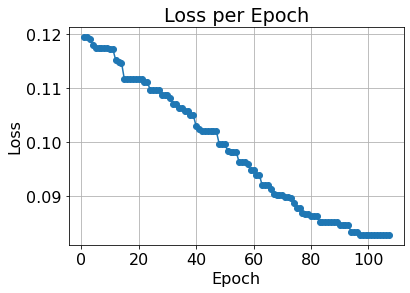

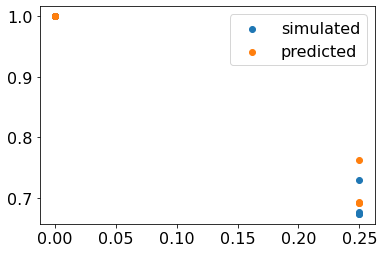

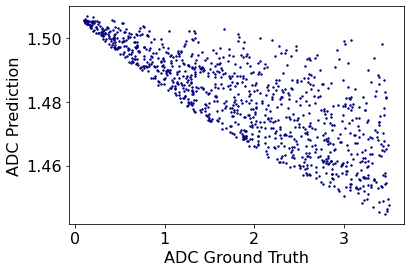

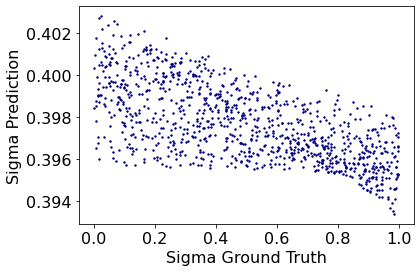

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


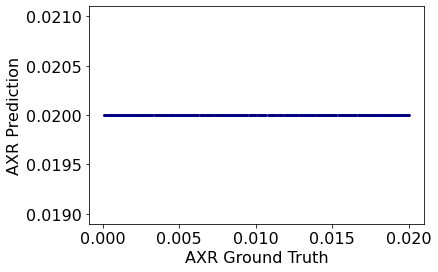

[(-0.7939168510885177, 7.190968271163526e-218), (-0.6535319138096022, 7.349402499503758e-123), (nan, nan)]


In [55]:
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

final_pred_E_vox_detached = final_pred_E_vox.detach().numpy()
"""Was having numpy pytorch issues, so this line helps fix it a bit."""

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox_detached[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
